# Imports

In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
# from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier, XGBRegressor
from imblearn.datasets import make_imbalance
from category_encoders.target_encoder import TargetEncoder
import statsmodels.api as sm
import datetime as dt
import category_encoders as ce

In [3]:
start=dt.datetime.now()
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.000058


# Functions

In [4]:
def upsample_classes(data, target):
    
    labels = list(data[target].unique())
    i = 0
    lst = []
    while len(lst) < len(labels):
        lst.append(labels[i])
        i+=1
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    a = pd.concat(classes)
    maj_class = a[a[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    b = pd.concat(new_classes)
    upsample = pd.concat([a[a[target]==class_lab],b])

    return upsample

In [5]:
te = TargetEncoder()

In [6]:
def target_encoding(data, column, target):
    
    grouped = data[[column,target]].groupby(column,as_index=False).mean()
    empty_dict = {}
    for i in range(len(grouped)):
        empty_dict[grouped.iloc[i,0]]=grouped.iloc[i,1]
    data[column]=data[column].map(lambda x: empty_dict[x])
    
    return data

In [7]:
def encode_cat(df, categorical_features):
    for cat in categorical_features:
        dummy_df = df[[cat,'Target']].groupby([cat],as_index=False).mean()
        dummy_dict = {}
        for i in range(len(dummy_df)):
            dummy_dict[dummy_df.iloc[i,0]]=float(dummy_df.iloc[i,1])
        df[cat] = df[cat].map(lambda x: dummy_dict[x])

In [8]:
def classification_model(X,y,method,target,test_balance = False):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=14)
    
    train = pd.concat([X_train,y_train],axis=1)
    
    train_balanced = upsample_classes(train, target)
    
    X_train = train_balanced.drop(target, axis=1)
    y_train = train_balanced[target]
    
    if test_balance == True:
        test = pd.concat([X_test,y_test],axis=1)
        test_balanced = upsample_classes(test, len(y.unique()), target)
        X_test = test_balanced.drop(target, axis=1)
        y_test = test_balanced[target]
    
    method.fit(X_train,y_train)
    p = method.predict(X_test)
    
    print('accuracy score')
    print(f1_score(y_test, p ,average='micro'))
    print('-'*20)
    
    plt.figure(figsize=(15,8))
    sns.heatmap(confusion_matrix(y_test,p))
    plt.tight_layout()
    plt.show()

# First pipeline

In [9]:
df = pd.read_csv('df_pipe.csv')

In [10]:
df.duplicated().sum()

0

In [11]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [12]:
dfdf = df.drop(['cut','clarity'],axis=1)

In [13]:
labs = LabelEncoder()

#### Here, I tried to use the label encoder on the color feature but I wasn't sure why it was needed. Using the OneHotEncoder would already transform the values to be numerical. When I included the 'column_trans_lab' pipeline I kept getting the 'fit_transform() takes 2 positional arguments but 3 were given' error. 

In [ ]:
column_trans_hot = make_column_transformer(
    (OneHotEncoder(drop='first'), ['cut', 'color','clarity']),
    remainder='passthrough')

column_trans_lab = make_column_transformer(
    (labs, ['color']),
    remainder='passthrough')

#### Here, I wasn't able to get pipe_basic_hot or pipe_basic_lab to fit to X_train. I think it has something to do with the 'make_pipeline' function. I was able to get them working by using the regular 'Pipeline' function though.

In [15]:
ma = MaxAbsScaler()
svm = SVC()

In [16]:
# pipe_basic_hot = make_pipeline(column_trans_hot, ma, svm)
# pipe_basic_lab = make_pipeline(column_trans_lab, ma, svm)

In [ ]:
#Now combining the column_trans_hot transformer, MaxAbsScaler, and the SVC classifier
pipe_basic_hot = Pipeline([
    ('col_trans_hot', column_trans_hot),
    ('ma', ma),
    ('clf', SVC())
])

In [18]:
print(df.shape)
df.head()

(53250, 10)


,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [19]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [20]:
# df=df.sample(n=5000)

In [21]:
df.shape

(53250, 9)

In [22]:
X = df.drop(['price','price_bin'],axis=1)
y = df.price_bin

In [23]:
# balance_df = upsample_classes(pd.concat([X,y],axis=1),'price_bin')
# Xb = balance_df.drop(['price_bin'],axis=1)
# yb = balance_df.price_bin

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [25]:
upsample_train = upsample_classes(pd.concat([X_train,y_train],axis=1),'price_bin')

In [26]:
y_train

29722    0.0
39461    0.0
29883    0.0
51189    0.0
899      0.0
        ... 
24882    2.0
52546    0.0
21510    2.0
13393    1.0
10273    0.0
Name: price_bin, Length: 39937, dtype: float64

In [27]:
pipe_basic_hot.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('col_trans_hot',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['cut', 'color', 'clarity'])],
                                   verbose=False)),
                ('ma', MaxAbsScaler(copy=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=2

In [28]:
p = pipe_basic_hot.predict(X_test)

### The classification report directly below this cell is from the new pipeline

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9654
         1.0       0.88      0.87      0.87      2352
         2.0       0.78      0.79      0.78       845
         3.0       0.78      0.77      0.78       462

    accuracy                           0.94     13313
   macro avg       0.85      0.85      0.85     13313
weighted avg       0.94      0.94      0.94     13313



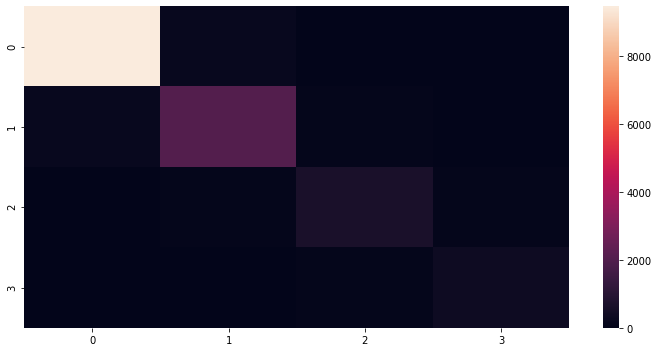

In [29]:
print(classification_report(p,y_test))

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(p,y_test))
plt.tight_layout()
plt.show()

#### Here's everything I did together

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      9628
         1.0       0.87      0.85      0.86      2386
         2.0       0.75      0.79      0.77       828
         3.0       0.81      0.78      0.79       471

    accuracy                           0.94     13313
   macro avg       0.85      0.85      0.85     13313
weighted avg       0.94      0.94      0.94     13313



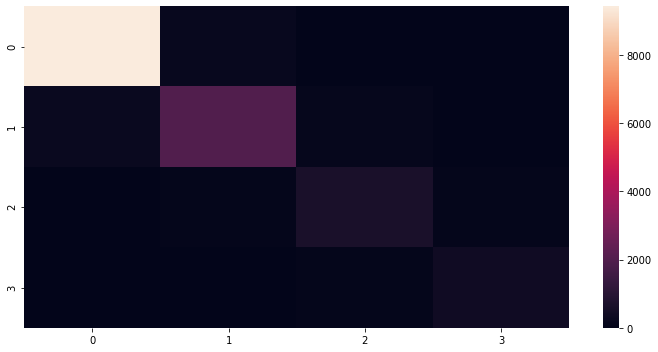

In [30]:
df = pd.read_csv('df_pipe.csv')

df.drop_duplicates(inplace=True)

df.drop('Unnamed: 0',axis=1,inplace=True)

X = df.drop(['price','price_bin'],axis=1)
y = df.price_bin

X_train, X_test, y_train, y_test = train_test_split(X,y)



#Putting MaxAbsScaler in pipeline
ma = Pipeline([
    ('ma', MaxAbsScaler())
])

#Now combining the column_trans_hot transformer, MaxAbsScaler, and the SVC classifier
pipe_basic_hot = Pipeline([
    ('col_trans_hot', column_trans_hot),
    ('ma', ma),
    ('clf', SVC())
])

pipe_basic_hot.fit(X_train,y_train)

p = pipe_basic_hot.predict(X_test)

print(classification_report(p,y_test))

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(p,y_test))
plt.tight_layout()
plt.show()

# 

# 

### This is the classification report from the original notebook

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       920
         1.0       0.79      0.82      0.81       234
         2.0       0.48      0.45      0.46        71
         3.0       0.37      0.76      0.49        25

    accuracy                           0.90      1250
   macro avg       0.66      0.75      0.68      1250
weighted avg       0.91      0.90      0.90      1250



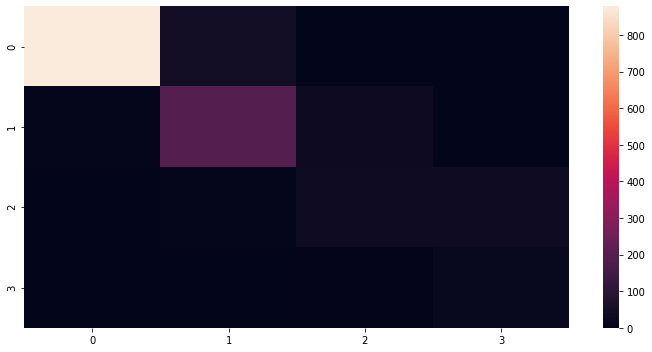

In [30]:
print(classification_report(p,y_test))

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(p,y_test))
plt.tight_layout()
plt.show()

### As far as the class imbalance goes, the upsample function you made is awesome! I'm going to try SMOTE and RandomUnderSampling from sklearn to see how those will perform while preserving the class balance.

#### In order to run SMOTE in the Pipeline I had to upgrade both sklearn and imbalanced learn. It may be easier to restart the kernel and only run the cells below.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from imblearn.pipeline import make_pipeline, pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
import datetime as dt

In [2]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average='micro')
    recall = recall_score(y, y_hat, average='micro')
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat, average='micro')
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [5]:
df = pd.read_csv('df_pipe.csv')

df.drop_duplicates(inplace=True)

df.drop('Unnamed: 0',axis=1,inplace=True)

X = df.drop(['price','price_bin'],axis=1)
y = df.price_bin

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

In [6]:
df.head()

,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [7]:
cont_feats = ['carat', 'depth', 'table', 'volume']
cat_feats = ['cut', 'color', 'clarity']
smote_feats = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'volume']

In [8]:
cont_transformer = Pipeline(steps=[('ss', StandardScaler())])
cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(
        transformers=[
            ('cont', cont_transformer, cont_feats),
             ('cat', cat_transformer, cat_feats)])

pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', RandomForestClassifier())])

In [9]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'volume']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('classifier', RandomForestClassifier())])

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9665
         1.0       0.87      0.88      0.88      2274
         2.0       0.78      0.79      0.78       864
         3.0       0.84      0.80      0.82       510

    accuracy                           0.94     13313
   macro avg       0.87      0.86      0.86     13313
weighted avg       0.94      0.94      0.94     13313

Recall:  0.9439645459325471
Accuracy:  0.9439645459325471
Precision:  0.9439645459325471
F1:  0.9439645459325471


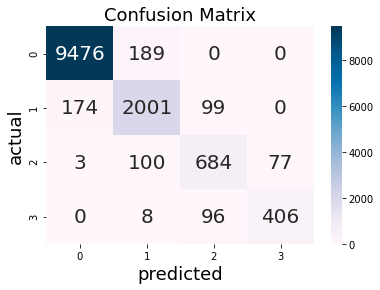

In [10]:
y_hat = pipe.predict(X_test)

print(classification_report(y_hat, y_test))
evaluation(y_hat, y_test)

#### Using SMOTE to oversample the minority class

In [11]:
smote = SMOTE()

In [12]:
pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('smote', smote),
                       ('classifier', RandomForestClassifier(random_state=42))])


              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9534
         1.0       0.89      0.87      0.88      2339
         2.0       0.82      0.77      0.79       931
         3.0       0.83      0.79      0.81       509

    accuracy                           0.94     13313
   macro avg       0.88      0.85      0.87     13313
weighted avg       0.94      0.94      0.94     13313

Recall:  0.9433636295350409
Accuracy:  0.9433636295350409
Precision:  0.9433636295350409
F1:  0.943363629535041


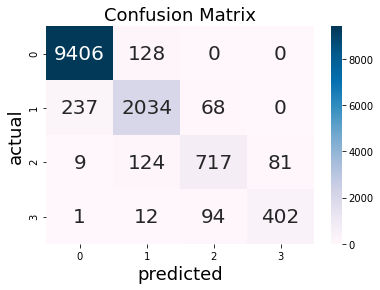

In [13]:
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
print(classification_report(y_hat, y_test))
evaluation(y_hat, y_test)

#### Adding Smote oversampling in the pipeline improved the performance a bit but not by much

# 

### Using 'StratifiedKFold' as the cross validator to preserve the distribution of classes.

Recall:  0.9406535620383123
Accuracy:  0.9406535620383123
Precision:  0.9406535620383123
F1:  0.9406535620383123


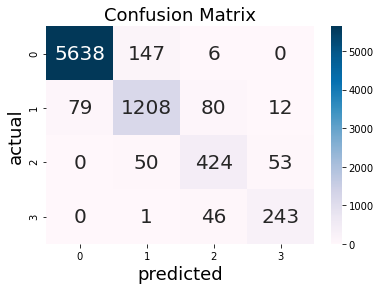

None
Average training accuracy: 
 0.9993677521358743
Average validation accuracy: 
 0.9437363319299722
Average training recall: 
 0.9993677521358743
Average validation recall: 
 0.9437363319299722
Elapsed time:  0:00:41.697416


In [14]:
start=dt.datetime.now()

srp = Pipeline(steps=[('preprocess', preprocessor),
                      ('smote', smote),
                      ('classifier', RandomForestClassifier())])

cv = StratifiedKFold()
rf_smote_train_acc = []
rf_smote_test_acc = []
rf_smote_train_recall = []
rf_smote_test_recall = []
for train_ind, val_ind in cv.split(X_train, y_train):
    X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
    srp.fit(X_t, y_t)
    y_hat_t = srp.predict(X_t)
    
    rf_smote_train_acc.append(accuracy_score(y_t, y_hat_t))
    rf_smote_train_recall.append(recall_score(y_t, y_hat_t, average='micro'))
    
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    y_hat_val = srp.predict(X_val)
    
    rf_smote_test_acc.append(accuracy_score(y_val, y_hat_val))
    rf_smote_test_recall.append(recall_score(y_val, y_hat_val, average='micro'))
    
print(evaluation(y_val, y_hat_val))
print('Average training accuracy: \n', np.mean(rf_smote_train_acc))
print('Average validation accuracy: \n', np.mean(rf_smote_test_acc))
print('Average training recall: \n', np.mean(rf_smote_train_recall))
print('Average validation recall: \n', np.mean(rf_smote_test_recall))

print('Elapsed time: ',str(dt.datetime.now()-start))

# 

### Evaluating on the holdout test set

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      9540
         1.0       0.89      0.87      0.88      2356
         2.0       0.80      0.78      0.79       903
         3.0       0.84      0.79      0.81       514

    accuracy                           0.94     13313
   macro avg       0.87      0.85      0.86     13313
weighted avg       0.94      0.94      0.94     13313

Recall:  0.9434387440847292
Accuracy:  0.9434387440847292
Precision:  0.9434387440847292
F1:  0.943438744084729


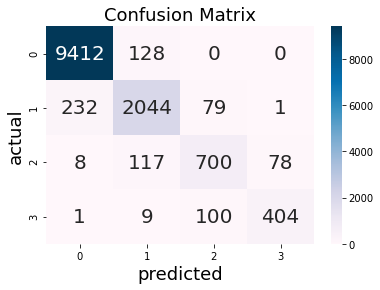

None
Average training accuracy: 
 0.9993677521358743
Average validation accuracy: 
 0.9437363319299722
Average training recall: 
 0.9993677521358743
Average validation recall: 
 0.9437363319299722
Elapsed time:  0:00:10.185152


In [15]:
start=dt.datetime.now()

srp.fit(X_train, y_train)

y_hat = srp.predict(X_test)

print(classification_report(y_hat, y_test))
print(evaluation(y_hat, y_test))
print('Average training accuracy: \n', np.mean(rf_smote_train_acc))
print('Average validation accuracy: \n', np.mean(rf_smote_test_acc))
print('Average training recall: \n', np.mean(rf_smote_train_recall))
print('Average validation recall: \n', np.mean(rf_smote_test_recall))

print('Elapsed time: ',str(dt.datetime.now()-start))

# 

# 

#### With Grid Search and SVM

In [24]:
start=dt.datetime.now()

pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('smote', smote),
                       ('rf', RandomForestClassifier())])

rand_forest_parms = {'rf__n_estimators': [100, 300],
                     'rf__max_depth':[4, 6, 8],
                     'rf__min_samples_split': [2, 4],
                     'rf__min_samples_leaf': [1, 2]}


gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=rand_forest_parms,
                  scoring='accuracy',
                  verbose=1)

gridsearch.fit(X_train, y_train)

print('Elapsed time: ',str(dt.datetime.now()-start))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 15.3min finished


Elapsed time:  0:15:37.840709


              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      8886
         1.0       0.87      0.68      0.76      2923
         2.0       0.70      0.68      0.69       903
         3.0       0.86      0.69      0.77       601

    accuracy                           0.89     13313
   macro avg       0.84      0.76      0.79     13313
weighted avg       0.89      0.89      0.88     13313

Recall:  0.8898820701569894
Accuracy:  0.8898820701569894
Precision:  0.8898820701569894
F1:  0.8898820701569894


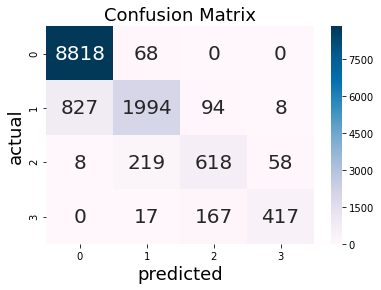

None
Average training accuracy: 
 0.9993677521358743
Average validation accuracy: 
 0.9437363319299722
Average training recall: 
 0.9993677521358743
Average validation recall: 
 0.9437363319299722


In [25]:
y_hat = gridsearch.predict(X_test)

print(classification_report(y_hat, y_test))
print(evaluation(y_hat, y_test))
print('Average training accuracy: \n', np.mean(rf_smote_train_acc))
print('Average validation accuracy: \n', np.mean(rf_smote_test_acc))
print('Average training recall: \n', np.mean(rf_smote_train_recall))
print('Average validation recall: \n', np.mean(rf_smote_test_recall))

# ############################################

# 

# Gridsearch

In [28]:
start=dt.datetime.now()

parameters = {'C': [0.1, 1, 10, 100, 1000],  'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  

CV = GridSearchCV(svm, parameters,refit = True, verbose = 0)
CV.fit(X_train.select_dtypes(exclude='O'), y_train)   

print('Best score and parameter combination')

print(CV.best_score_)    
print(CV.best_params_) 

print('Elapsed time: ',str(dt.datetime.now()-start))

Best score and parameter combination = 
0.958053662509108
{'C': 1000, 'gamma': 1}


# Pipeline function

In [ ]:
def function():
    pass

# Second pipeline

In [27]:
df = pd.read_csv('df_pipe.csv')

In [28]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [29]:
ma = MaxAbsScaler()
ss = StandardScaler()

In [30]:
df_num = df.select_dtypes(exclude='O').drop(['price','price_bin'],axis=1)
df_cat = df.select_dtypes(include='O')
df_tar = df[['price','price_bin']]

In [31]:
df_num=pd.DataFrame(ma.fit_transform(df_num),columns=df.select_dtypes(exclude='O').drop(['price','price_bin'],axis=1).columns)

In [32]:
df2=pd.concat([df_num,df_cat,df_tar],axis=1)

In [33]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df2.drop('Unnamed: 0',axis=1,inplace=True)

In [35]:
df2.head()

,carat,depth,table,volume,cut,color,clarity,price,price_bin
0,0.093878,0.922039,0.846154,0.094664,Ideal,E,SI2,326.0,0.0
1,0.085714,0.896552,0.938462,0.085505,Premium,E,SI1,326.0,0.0
2,0.093878,0.853073,1.000000,0.094354,Good,E,VS1,327.0,0.0
3,0.118367,0.935532,0.892308,0.115783,Premium,I,VS2,334.0,0.0
4,0.126531,0.949025,0.892308,0.128650,Good,J,SI2,335.0,0.0


In [40]:
for col in df.select_dtypes(include='O').columns:
    df[col]=target_encoding(df,col,'price')

In [41]:
for col in df2.select_dtypes(include='O').columns:
    df2[col]=target_encoding(df2,col,'price')

In [42]:
df2.head()

,carat,depth,table,volume,cut,color,clarity,price,price_bin
0,0.093878,0.922039,0.846154,0.094664,0.0938776,0.0938776,0.0938776,326.0,0.0
1,0.085714,0.896552,0.938462,0.085505,0.0857143,0.0857143,0.0857143,326.0,0.0
2,0.093878,0.853073,1.000000,0.094354,0.0938776,0.0938776,0.0938776,327.0,0.0
3,0.118367,0.935532,0.892308,0.115783,0.118367,0.118367,0.118367,334.0,0.0
4,0.126531,0.949025,0.892308,0.128650,0.126531,0.126531,0.126531,335.0,0.0


In [43]:
df.head()

,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0.23,0.23,0.23,0.23,61.5,55.0,38.202030,0.0,326.0
1,0.21,0.21,0.21,0.21,59.8,61.0,34.505856,0.0,326.0
2,0.23,0.23,0.23,0.23,56.9,65.0,38.076885,0.0,327.0
3,0.29,0.29,0.29,0.29,62.4,58.0,46.724580,0.0,334.0
4,0.31,0.31,0.31,0.31,63.3,58.0,51.917250,0.0,335.0


In [44]:
X=df.drop(['price','price_bin'],axis=1)
y1=df.price_bin
y2=df.price

In [45]:
logreg=LogisticRegression(random_state=14)
cross_val_score(logreg, X, y1, cv=5, scoring='accuracy').mean()

0.8298591549295775

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y1)

In [47]:
upsample_train = upsample_classes(pd.concat([X_train,y_train],axis=1),'price_bin')

In [48]:
X_train=upsample_train.drop('price_bin',axis=1)
y_train=upsample_train.price_bin

In [49]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca',PCA(n_components=6)), ('svc', SVC())])

In [27]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('svc', SVC())])

In [28]:
p=pipe.predict(X_test)

In [29]:
print(classification_report(p,y_test))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      8470
         1.0       0.80      0.55      0.65      3285
         2.0       0.76      0.44      0.55      1558
         3.0       0.00      0.00      0.00         0

    accuracy                           0.82     13313
   macro avg       0.61      0.49      0.53     13313
weighted avg       0.84      0.82      0.82     13313



# 

# 

#### The only thing I could figure out as to why the grid search wasn't running is just that the 'cut' feature didn't get encoded. I ended up just created variables for the continuous and categorical columns like this:

cont_transformer = Pipeline(steps=[('ss', StandardScaler())])
cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(
        transformers=[
            ('cont', cont_transformer, cont_feats),
             ('cat', cat_transformer, cat_feats)])

pipe = Pipeline(steps=[('preprocess', preprocessor),
                       ('classifier', RandomForestClassifier())])
                       
                 
#### I think most of the issues came from the version of sklearn and imbalaced learn. For the transformers above I had to restart the kernel and remove the Pipeline import from sklearn.pipeline. I then imported Pipeline, and make_pipeline from Imbalanced-learn. This seemed to work the best for me when including SMOTE in the pipeline.

#### I did include a grid search in my code after the cell with the Stratified KFold cross validation. I tried to run a grid search with the SVC model but after 4 hours, nothing. I'm not sure if it was still trying to total the fits from the parameter grid but I couldn't get it to complete. I was able to run a grid search with Random Forest.

# Pipeline with Gridsearch

In [59]:
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('svm', SVC(random_state=14))])

grid = [{'svm__kernel': ['poly', 'sigmoid'],
         'svm__C': [0.01, 1, 100],
         'svm__degree': [2,3,4,5],
         'svm__gamma': [0.001, 0.01]}]

gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

gridsearch.fit(X_train, y_train)

ValueError: could not convert string to float: 'Ideal'